In [2]:
import argparse
import os
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import dataloader
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

In [3]:
# pretrained_model=net(previously used in training)
def pretrained_model(num_output_class, device, fine_tune):
    '''
    TODO: Complete this function that initializes your model
          Remember to use a pretrained model
    '''
    model_conv = models.resnet18(pretrained=True)
    model_conv.eval()
    if not fine_tune:
        for param in model_conv.parameters():
            param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_output_class)
    return model_conv.to(device)

In [4]:
# Load previously trained model
data_dir = os.path.normpath(r'./data/Image/')
model_path = './Model/SGD_scheduler_fine_tune.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = datasets.ImageFolder(os.path.join(data_dir, 'test')).classes
num_output_class = len(class_names)
checkpoint = torch.load(model_path, map_location=device)
fine_tune = True
model = pretrained_model(num_output_class, device, fine_tune)
model.load_state_dict(checkpoint)

C:\Users\l501l\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\l501l\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# Lime

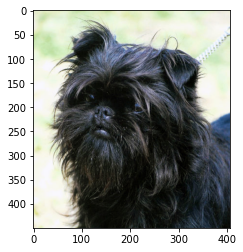

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./data/Image/test/001.Affenpinscher/Affenpinscher_00023.jpg')
plt.imshow(img)

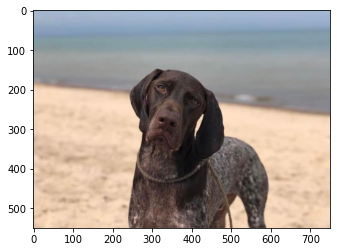

In [6]:
img = get_image('./data/Image/277352595_716937106101646_1750604768376802490_n.jpg')
plt.imshow(img)

In [7]:
pil_trans = nn.Sequential(
    transforms.Resize(256),
    transforms.CenterCrop(224)
)
   
tensor_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])  
]) 

In [9]:
def batch_predict(batch_images):
    batch = torch.stack(tuple(tensor_trans(i) for i in batch_images), dim=0)
    outputs = model(batch)
    probs = F.softmax(outputs, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pil_trans(img)])

In [11]:
class_names[test_pred.argmax()]

'072.German_shorthaired_pointer'

In [12]:
test_pred = batch_predict([pil_trans(img)])

In [13]:
from lime import lime_image

In [57]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_trans(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=100) # number of images that will be sent to classification function

  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
from skimage.segmentation import mark_boundaries

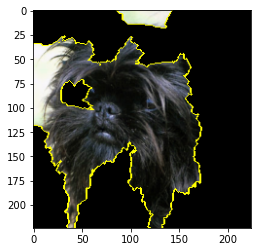

In [59]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

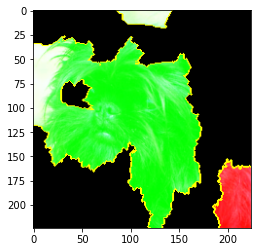

In [61]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [78]:
def dog_breed_explain(breed_id):
    img_list = []
    path = './data/Image/test/' + breed_id
    files = os.listdir(path)
    for file in files:
        img_list.append(get_image(path + '/' + file))
    for img in img_list:
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(np.array(pil_trans(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
        img_boundry1 = mark_boundaries(temp/255.0, mask)

        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
        img_boundry2 = mark_boundaries(temp/255.0, mask)
        print(f'Predicted breed:{class_names[batch_predict([pil_trans(img)]).argmax()]}')
        figure, axis = plt.subplots(1, 3, figsize=(10,4))
        figure.tight_layout(pad=5.0)
        axis[0].imshow(img_boundry1)
        axis[1].imshow(pil_trans(img))
        axis[2].imshow(img_boundry2)
        plt.show()
    return None

In [76]:
breed_id = '044.Cane_corso'

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:044.Cane_corso


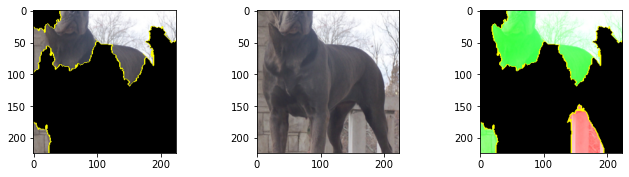

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:034.Boxer


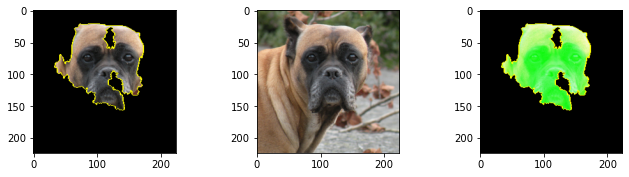

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:096.Labrador_retriever


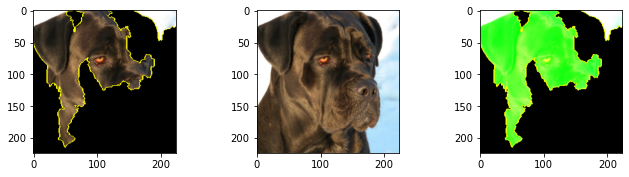

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:044.Cane_corso


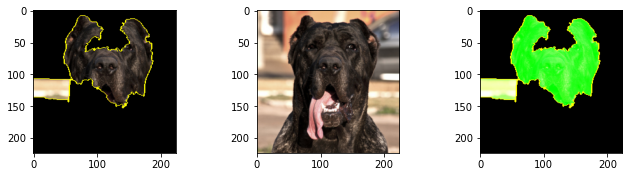

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:044.Cane_corso


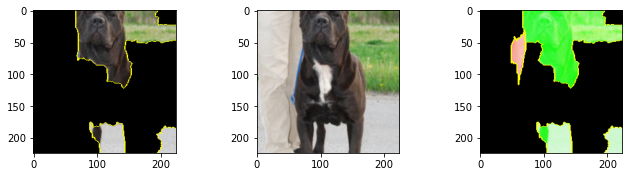

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:044.Cane_corso


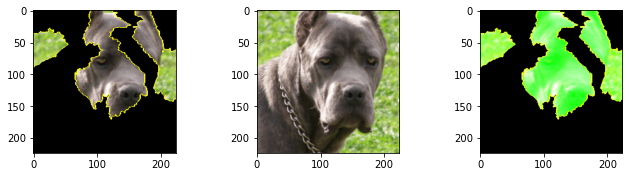

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:044.Cane_corso


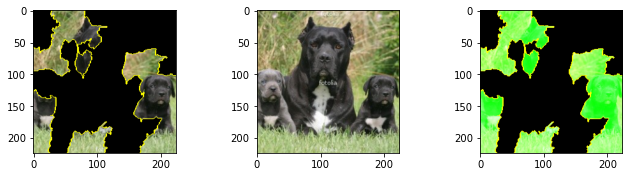

  0%|          | 0/1000 [00:00<?, ?it/s]

Predcited breed:078.Great_dane


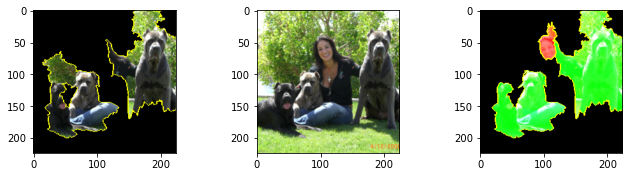

In [77]:
dog_breed_explain(breed_id)

In [79]:
breed_id = '034.Boxer'

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


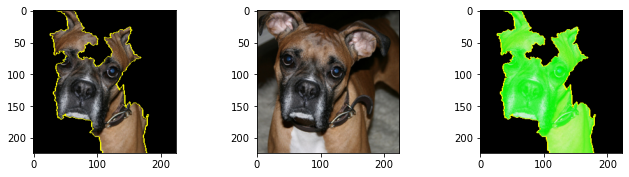

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:041.Bullmastiff


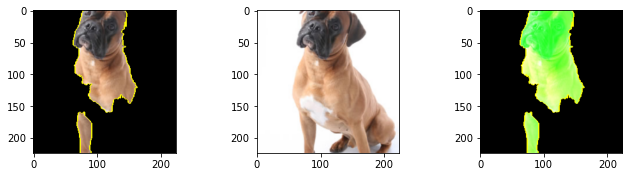

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


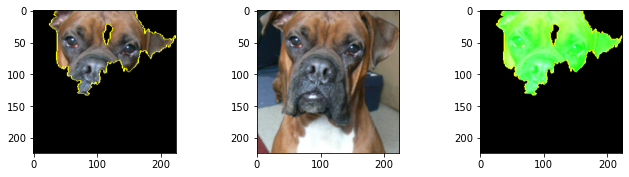

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


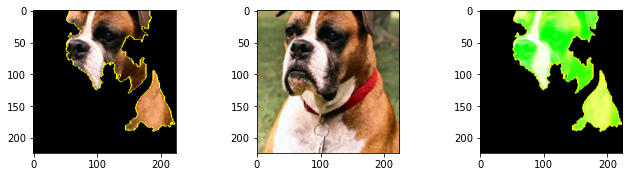

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


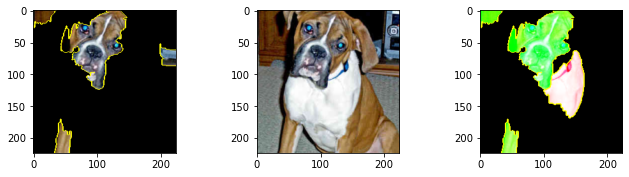

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


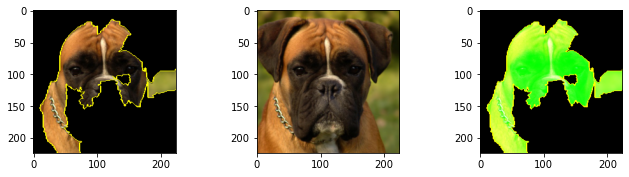

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


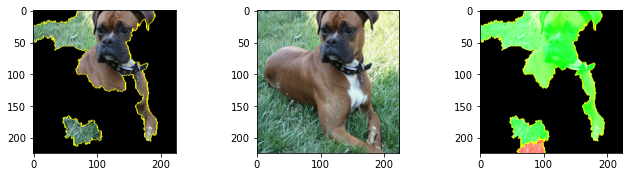

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted breed:034.Boxer


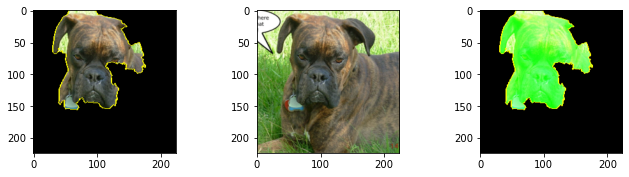

In [80]:
dog_breed_explain(breed_id)